# Value-added Guide Star Catalogue 

### Rationale
ELT will need a Guide Star Catalogue with good astrometry (few mas positional uncertainty) and reliable fluxes in the NIR. 

### Deliverable
This is a draft/PoC version of such a catalogue. All astrometry is based on Gaia EDR3, which means that the reference epoch for the astrometry is 2016.0. Coordinates and proper motions are given w.r.t. this reference.

NIR photometry is added based on cross-matches (within 0.5'') with several NIR surveys. These are:<br>
-UltraVISTA<br>
-VIKING<br>
-VVV, particularly the VIRAC reduction and catalogue (not yet VIRAC2)<br>
-VHS<br>
-VMC, which does not include H-band<br>
-UKIDSS3 which uses the UKIRT telescope<br>
From these surveys, we add Y-, J-, H-, and Ks-band fluxes, whenever available.

We also add two "predictors" of NIR flux based on optical data:<br>
-H-band flux based on PS1 optical data we run our predictor from Workbook 1, which can be applied to sources North of Dec>-30 degrees.<br>
-J-band flux based on predictor used by MUSE IOT team, which is based on Gaia data only. This can thus be applied to all objects that have 3-band photometry from Gaia.

### Use
RA, Dec have to be provided in degrees in the ICRS system. Halfboxsize is given in degrees. The final catalogue spans a rectangular area with a side length of 2*Halfboxsize degrees, and is centred on the main coordinate.

### Future steps:
-Train predictors on other data sets. Initially DES, later LSST/Vera Rubin.<br>
-Correct for proper motion when matching two catalogues, especially when the photometry is taken several years apart.


In [1]:
# BASIC FUNCTIONS AND MODULES
import seaborn as sns
import sys
import math
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import six
from pyvo.dal import tap
import matplotlib
from matplotlib.pylab import plt
import time
import pydot

# Astropy
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astropy.coordinates.tests.utils import randomly_sample_sphere
from astroquery.esasky import ESASky
from astropy.coordinates import match_coordinates_sky
from astropy.stats import sigma_clipped_stats

#Tensorflow specific
# Make numpy printouts easier to read.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


#SQL setup
VIZIER_TAP_CAT = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap"
tapcatvizier = tap.TAPService(VIZIER_TAP_CAT)
def query_Gaia(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT Source, RA_ICRS, DE_ICRS, pmRA, pmDE, Gmag, "BP-RP" as BPmRP, RUWE, epsi, sepsi
    FROM "I/350/gaiaedr3"
    WHERE RA_ICRS > %f AND RA_ICRS < %f AND DE_ICRS > %f AND DE_ICRS < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query)
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_Gaia_PS1(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT gaia.Source, gaia.Gmag, "BP-RP" as BPmRP, "BP-G" as BPmG,
    ps1.gmag-rmag as gmr, rmag-imag as rmi, imag-zmag as imz, zmag-ymag as zmy, gaia.Gmag-rmag as Gmr,
    "b_rmag" as rmagmin, "B_rmag" as rmagmax, ps1.e_gmag, ps1.gmagStd, ps1.e_rmag, ps1.rmagStd, ps1.e_imag, ps1.imagStd
    FROM "I/350/gaiaedr3" AS Gaia, "II/349/ps1" as PS1
    WHERE RA_ICRS > %f AND RA_ICRS < %f AND DE_ICRS > %f AND DE_ICRS < %f AND objID = PS1"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query)
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_vvv(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RA_ICRS as RAJ2000, DE_ICRS as DEJ2000, Ymag, Jmag, Hmag, Ksmag 
    FROM "II/364/virac" 
    WHERE RA_ICRS > %f AND RA_ICRS < %f AND DE_ICRS > %f AND DE_ICRS < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query)
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_viking(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RAJ2000, DEJ2000, Yap3 as Ymag, Jap3 as Jmag, Hap3 as Hmag, Ksap3 as Ksmag
    FROM "II/343/viking2" 
    WHERE RAJ2000 > %f AND RAJ2000 < %f AND DEJ2000 > %f AND DEJ2000 < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query) 
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_uvista(ra_search, dec_search, halfboxsize):
    """Change to Vega magnitudes"""
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RAJ2000, DEJ2000, Ymag-0.634 as Ymag, Jmag-0.91 as Jmag, Hmag-1.39 as Hmag, Ksmag-1.85 as Ksmag
    FROM "J/A+A/544/A156/catalog" 
    WHERE RAJ2000 > %f AND RAJ2000 < %f AND DEJ2000 > %f AND DEJ2000 < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query) 
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_vhs(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RAJ2000, DEJ2000, Yap3 as Ymag, Jap3 as Jmag, Hap3 as Hmag, Ksap3 as Ksmag
    FROM "II/367/vhs_dr5" 
    WHERE RAJ2000 > %f AND RAJ2000 < %f AND DEJ2000 > %f AND DEJ2000 < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query) 
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_vmc(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RAJ2000, DEJ2000, Yap3 as Ymag, Jap3 as Jmag, Ksap3 as Ksmag
    FROM "II/351/vmc_dr4" 
    WHERE RAJ2000 > %f AND RAJ2000 < %f AND DEJ2000 > %f AND DEJ2000 < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query) 
    df_vizier = res.to_table().to_pandas()
    return df_vizier

def query_ukidss(ra_search, dec_search, halfboxsize):
    minra = ra_search-halfboxsize
    maxra = ra_search+halfboxsize
    mindec = dec_search-halfboxsize
    maxdec = dec_search+halfboxsize
    query="""SELECT RAJ2000, DEJ2000, Ymag, Jmag1 as Jmag, Hmag, Kmag as Ksmag
    FROM "II/319/las9" 
    WHERE RAJ2000 > %f AND RAJ2000 < %f AND DEJ2000 > %f AND DEJ2000 < %f"""  % (minra, maxra, mindec, maxdec) 
    res = runqueryvizier(query) 
    df_vizier = res.to_table().to_pandas()
    return df_vizier


def runqueryvizier(query):
    """Make sure the query runs, even if connection is lost. Retry a few times"""
    retry_flag = True
    retry_count = 0
    while retry_flag and retry_count < 5:
        try:
            res = tapcatvizier.search(query=query)
            retry_flag = False
        except Exception as e:
            print (e)
            print ("Retry after 5 sec")
            retry_count = retry_count + 1
            time.sleep(5)
    return res



In [2]:
# Main function to generate catalogue
def make_cat(ra, dec, halfbox=5./60.):  #default halfbox is ELT FoV
    def update_cat(df_nir, df, tag):
        """This does the cross-matching between the main catalogue df, and a NIR catalogue df_nir. 
        The function returns the updated catalogue, where new columns are added."""
        if len(df_nir) > 9999.:
            print("TOO MANY SOURCES FOR MATCHING")
            return df
        if len(df_nir) > 0.5:
            catalog = SkyCoord(ra=df['RA_ICRS']*u.degree, dec=df['DE_ICRS']*u.degree)
            c = SkyCoord(ra=df_nir['RAJ2000']*u.degree, dec=df_nir['DEJ2000']*u.degree)
            idx, d2d, d3d = catalog.match_to_catalog_sky(c)
            selarr=((d2d.arcsec < 0.5))
            df.loc[selarr,tag+'matchdistarcsec'] = d2d[selarr].arcsec
            columnsubset = ['Ymag', 'Jmag','Hmag','Ksmag'] # columns to be considered
            for columni in columnsubset:
                if columni in df_nir.columns:
                    df.loc[selarr,tag+columni] = df_nir.loc[idx[selarr],columni].values    
        return df

    def add_Jmag(df):
        df['MUSEIOT_Jmag'] = df['Gmag']-0.058-1.367*df['BPmRP']+0.108*(df['BPmRP'])**2
        return df
    
    # Gaia base catalogue
    df = query_Gaia(ra, dec, halfbox).set_index('Source')

    # Cross-match with different surveys:
    for survey in ['uvista','viking','vvv','vhs','vmc','ukidss']:
        exec(f'df_nir = query_{survey}({ra:.2f},{dec:.2f},{halfbox:.2f})')
        exec(f'df = update_cat(df_nir, df, "{survey}_")')

    # Add PS1-based H-band colour
    df_PS = query_Gaia_PS1(ra, dec, halfbox).set_index('Source')    
    SEL = ((df_PS['gmagStd'] > 0.5) & (df_PS['gmagStd'] > 3.*df_PS['e_gmag'])) | \
        ((df_PS['rmagStd'] > 0.5) & (df_PS['rmagStd'] > 3.*df_PS['e_rmag'])) | \
        ((df_PS['imagStd'] > 0.5) & (df_PS['imagStd'] > 3.*df_PS['e_imag'])) # Remove unreliable sources, same as when model was trained
    df_PS = df_PS[~SEL] 
    if len(df_PS) > 0.5: # Otherwise there is no PS1 information
        dnn_model = tf.keras.models.load_model('./dnn_model_PS1')
        df_PS['GminHpredict'] = dnn_model.predict(df_PS[['BPmRP','BPmG','gmr','rmi','imz','zmy','Gmr']])
        df_PS['FromPS1_Hmag'] = df_PS['Gmag'] - df_PS['GminHpredict']
        df = df.join(df_PS[['FromPS1_Hmag']])
    
    #Add J-band magnitude from MUSE IOT:
    df = add_Jmag(df)
    # drop columns that contain no information:
    df.dropna(axis=1, how='all', inplace=True) 
    #adjust formatting for printing to file (but will change format from float to object):
    #for col in [s for s in df.columns.tolist() if ('mag' in s or 'matchdistarcsec' in s or 'epsi' in s or 'pm' in s or 'BPmRP' in s or 'RUWE' in s)]:
    #    df[col] = df[col].map(lambda x: '{:8.3f}'.format(x))
    #for col in [s for s in df.columns.tolist() if ('ICRS' in s)]:
    #    df[col] = df[col].map(lambda x: '{:13.7f}'.format(x))
    
    #show which surveys are included here:
    print([s for s in df.columns.tolist() if 'Jmag' in s])
    print([s for s in df.columns.tolist() if 'Hmag' in s])
    return  df



In [3]:
# Adjust these parameters:
ra=150.
dec=2.0
halfbox=0.1
df = make_cat(ra, dec, halfbox)
df.to_csv('guide_stars.dat')

['uvista_Jmag', 'ukidss_Jmag', 'MUSEIOT_Jmag']
['uvista_Hmag', 'ukidss_Hmag', 'FromPS1_Hmag']


In [4]:
df.head()

,RA_ICRS,DE_ICRS,pmRA,pmDE,Gmag,BPmRP,RUWE,epsi,sepsi,uvista_matchdistarcsec,uvista_Ymag,uvista_Jmag,uvista_Hmag,uvista_Ksmag,ukidss_matchdistarcsec,ukidss_Ymag,ukidss_Jmag,ukidss_Hmag,ukidss_Ksmag,FromPS1_Hmag,MUSEIOT_Jmag
Source,,,,,,,,,,,,,,,,,,,,,
3836037365974285184,149.963881,1.902470,-5.213,9.372,16.583500,1.171020,1.033,0.115,0.498705,0.201662,15.407,15.124,14.631,14.503,0.077249,15.475000,15.167000,14.599000,14.506000,14.627112,15.072814
3836037499118700160,149.935197,1.902610,5.880,-5.020,19.815300,2.253740,1.091,1.148,1.047959,0.132208,17.577,17.122,16.574,16.279,0.178891,17.587999,17.620001,16.483999,16.261000,16.476067,17.225006
3836037572132715648,149.920208,1.916471,-5.117,-2.345,17.645800,0.805422,1.012,0.000,0.000000,0.181127,16.824,16.634,16.294,16.189,0.154120,16.843000,16.688000,16.226999,16.113001,16.227673,16.556849
3836042343841811200,150.037830,1.908134,-3.204,-3.978,18.536600,0.700226,1.003,0.000,0.000000,0.159140,17.972,17.826,17.560,17.470,0.168236,17.969999,17.738001,17.495001,17.358000,17.478321,17.574345
3836042519935039616,150.003320,1.917266,NaN,NaN,21.124001,1.666130,NaN,15.736,9.025831,0.135403,17.044,16.531,15.835,15.144,0.109876,17.795000,17.238001,16.464001,15.746000,16.340897,19.088207


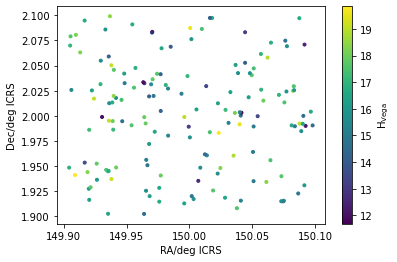

In [5]:
plt.scatter(df['RA_ICRS'],df['DE_ICRS'],c=df[[s for s in df.columns.tolist() if 'Hmag' in s][0]], marker='.')
plt.xlabel('RA/deg ICRS')
plt.ylabel('Dec/deg ICRS')
cbar = plt.colorbar()
cbar.set_label('$\mathrm{H_{Vega}}$') 
plt.show()